In [1]:
import random
import torch

# from utils.Logger import showPlot
# from utils.Timer import asMinutes, timeSince

%load_ext autoreload
from data.ConstList_Data import Lang, prepareData
from model.rnn_model.encoderRNN import EncoderGRU, EncoderLSTM
from model.rnn_model.decoderRNN import (
    DecoderGRU, DecoderLSTM, 
    AttnDecoderGRU, AttnDecoderLSTM1, AttnDecoderLSTM2
)
from model.seq2seq_Model import (
    Seq2Seq_batch_ptModel, 
    Seq2SeqTranslate_ptTokenizer,
)
from baselineJP_ExpTrain import example_ExpTrain
from baseline_ExpEval import evaluate_batch_randomly
%autoreload


DATA_DIR = '../'

## load data

## setup Experiment

In [2]:
MAX_LENGTH = 100

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## setup Data

In [3]:
%load_ext autoreload
from data.ConstList_Data import Lang, prepareData
%autoreload

## Data
input_lang, output_lang, pairs = prepareData(
        'shuffled_elements', 'src_elements', DATA_DIR, 
        max_length=MAX_LENGTH, copy_num=15, reverse=False)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Reading jsons...
['instruction', 'formula', '/formula', 'formula', 'ansColumn', '/formula', 'formula', '/formula', 'formula', 'ansColumn', 'ansColumn', '/formula', 'formula', '/formula', 'formula', 'ansColumn', '/formula', 'formula', 'ansColumn', '/formula', 'ansColumn', '/instruction', '/question', 'page_num', '/page_num']
570 2 117 117
ansColumn formula /page_num /question /formula ansColumn /formula /instruction formula page_num ansColumn /formula
Read 570 sentence pairs
Trimmed to 570 sentence pairs
Counting words...
Counted words:
shuffled_elements 27
src_elements 27


In [4]:
print(random.choice(pairs))
print(input_lang.n_words, output_lang.n_words)

('ansColumn /formula formula ansColumn formula formula formula /formula /formula /formula formula formula /formula formula ansColumn ansColumn /formula formula /formula /formula formula ansColumn formula /formula formula formula /formula ansColumn ansColumn /formula /formula /formula formula ansColumn ansColumn formula', 'formula /formula formula /formula formula /formula formula /formula formula /formula formula /formula formula ansColumn ansColumn /formula formula /formula formula /formula formula /formula formula ansColumn /formula formula ansColumn ansColumn /formula formula ansColumn /formula formula ansColumn ansColumn ansColumn')
27 27


In [5]:
# train / test split
from sklearn.model_selection import train_test_split
train_pairs, test_pairs = train_test_split(pairs, test_size=0.2)

## setup Model

In [6]:
## Model
tokenizer = Seq2SeqTranslate_ptTokenizer(
                    input_lang, output_lang, device)

### test

In [7]:
batch_size = 10
emb_size = 8
hid_size = 12

test_encoder = EncoderLSTM(input_lang.n_words, emb_size, hid_size)
test_decoder1 = AttnDecoderLSTM1(
                    emb_size, hid_size, output_lang.n_words,
                    device, max_length=MAX_LENGTH)
seq2seq_test_model = Seq2Seq_batch_ptModel(
                    tokenizer, device,
                    dropout_p=0.1, max_length=MAX_LENGTH)
seq2seq_test_model.set_models(test_encoder, test_decoder1)
seq2seq_test_model.exec_test(train_pairs, batch_size=batch_size)


[Info] input_batch.shape, input_lens.shape
     =  torch.Size([37, 10]) torch.Size([10])
[Info] enc_outputs.shape, hidden_h.shape, hidden_c.shape
     =  torch.Size([37, 10, 24]) torch.Size([1, 10, 12]) torch.Size([1, 10, 12])
[Info] hidden[0].shape, hidden[1].shape
     =  torch.Size([10, 12]) torch.Size([10, 12])
[Info] dec_outputs.shape, hidden[0].shape, hidden[1].shape, attn_weights.shape
     =  torch.Size([10, 27]) torch.Size([10, 12]) torch.Size([10, 12]) torch.Size([10, 100])
[Info] loss.item()
     =  3.3343424797058105


In [8]:
attn_size = 9

test_decoder2 = AttnDecoderLSTM2(
                    emb_size, hid_size, attn_size, 
                    output_lang.n_words, device).to(device)
seq2seq_test_model.set_models(test_encoder, test_decoder2)
seq2seq_test_model.exec_test(train_pairs, batch_size=batch_size)

[Info] input_batch.shape, input_lens.shape
     =  torch.Size([40, 10]) torch.Size([10])
[Info] enc_outputs.shape, hidden_h.shape, hidden_c.shape
     =  torch.Size([40, 10, 24]) torch.Size([1, 10, 12]) torch.Size([1, 10, 12])
[Info] hidden[0].shape, hidden[1].shape
     =  torch.Size([10, 12]) torch.Size([10, 12])
[Info] dec_outputs.shape, hidden[0].shape, hidden[1].shape, attn_weights.shape
     =  torch.Size([10, 27]) torch.Size([10, 12]) torch.Size([10, 12]) torch.Size([10, 40])
[Info] loss.item()
     =  3.1817595958709717


## setup Model

In [9]:
# %load_ext autoreload
# from model.rnn_model.decoderRNN import (
#     DecoderGRU, DecoderLSTM, 
#     AttnDecoderGRU, AttnDecoderLSTM1, AttnDecoderLSTM2
# )
# from model.seq2seq_Model import (
#     Seq2Seq_batch_ptModel, 
#     Seq2SeqTranslate_ptTokenizer,
# )
# from baselineJP_ExpTrain import example_ExpTrain
# from baselineJP_ExpTrain import example_ExpTrain
# %autoreload

load_model_dir = '_best_weight' if torch.cuda.is_available() else "_best_weight_CPU"

In [10]:
emb_size = 256  #1024
hidden_size = 256  #1024

def build_encoder(is_load_weights=False):
    encoder = EncoderLSTM(input_lang.n_words, emb_size, hidden_size)
    if is_load_weights:
        encoder.load_weights(
                    load_m_dir=f'_logs/{load_model_dir}', 
                    load_m_file_name='encoder.pth')
    return encoder


dec_types = ['LSTM', 'AttnLSTM1', 'AttnLSTM2']
attn_size = 1024
def build_decoder(dec_type:str, is_load_weights=False):
    decoder = None
    if dec_type == 'AttnLSTM1':
        decoder = AttnDecoderLSTM1(
                        emb_size, hidden_size, output_lang.n_words, 
                        device, max_length=MAX_LENGTH)
    elif dec_type == 'AttnLSTM2':
        decoder = AttnDecoderLSTM2(
                        emb_size, hidden_size, attn_size, 
                        output_lang.n_words, device)
    elif dec_type == 'LSTM':
        decoder = DecoderLSTM(
                        emb_size, hidden_size, attn_size, 
                        output_lang.n_words, device)

    if decoder is None:
        raise Exception(f'[Error] model : {dec_type} は存在しません。')
    
    if is_load_weights:
        decoder.load_weights(
                    load_m_dir=f'_logs/{load_model_dir}', 
                    load_m_file_name=f'decoder_{dec_type}.pth')
    return decoder

In [11]:
# Experiment
exp_train = example_ExpTrain(train_pairs, test_pairs)

## exec

In [12]:
%load_ext autoreload
from data.ConstList_Data import Lang, prepareData
from model.rnn_model.encoderRNN import EncoderGRU, EncoderLSTM
from model.rnn_model.decoderRNN import (
    DecoderGRU, DecoderLSTM, 
    AttnDecoderGRU, AttnDecoderLSTM1, AttnDecoderLSTM2
)
from model.seq2seq_Model import (
    Seq2Seq_batch_ptModel, 
    Seq2SeqTranslate_ptTokenizer,
)
from baselineJP_ExpTrain import example_ExpTrain
from baseline_ExpEval import evaluate_batch_randomly
%autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
# encoder
encoder = build_encoder()

# decoder
decoder = build_decoder('AttnLSTM1')

# seq2seq model
seq2seq_lstm_model = Seq2Seq_batch_ptModel(
                        tokenizer, device,
                        dropout_p=0.1, max_length=MAX_LENGTH,
                        save_m_dir='_logs', 
                        save_m_file_names=(
                            'encoder.pth', 'decoder_LSTM1.pth'))
seq2seq_lstm_model.set_models(encoder, decoder)

## exec
exp_train.exec(seq2seq_lstm_model, 
                # epochs=3, batch_size=100, 
#                 epochs=100, batch_size=50, 
                epochs=500, batch_size=100, 
                teacher_forcing=0.9, early_stopping=100)


  0%|          | 0/500 [00:00<?, ?it/s]/Users/m_ryo/.pyenv/versions/3.8.4/lib/python3.8/site-packages/nltk/translate/bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/Users/m_ryo/.pyenv/versions/3.8.4/lib/python3.8/site-packages/nltk/translate/bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/Users/m_ryo/.pyenv/versions/3.8.4/lib/python3.8/site-packages/nltk/translate/bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlap

KeyboardInterrupt: 

> formula /page_num /formula /formula page_num formula
= formula /formula formula /formula page_num /page_num
< /formula formula /formula formula /formula formula /formula formula /formula formula /formula formula /formula formula /formula formula /formula formula
bleu: 0.1431712315455507



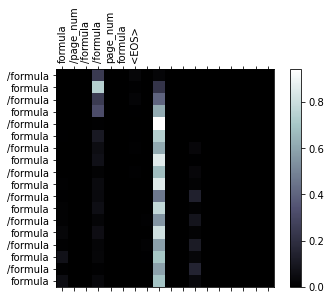

> formula page_num /formula /formula /formula formula formula formula /formula formula formula /formula /formula /formula /formula /formula formula formula /formula /formula /formula formula /question /formula /instruction /page_num formula formula formula
= /formula formula /formula formula /formula formula /formula formula /formula formula /formula formula /formula formula /formula formula /formula formula /formula formula /formula formula /formula formula /formula /instruction /question page_num /page_num
< /formula formula /formula formula /formula formula /formula formula /formula formula /formula formula /formula formula /formula formula /formula formula
bleu: 0.49367278838913037



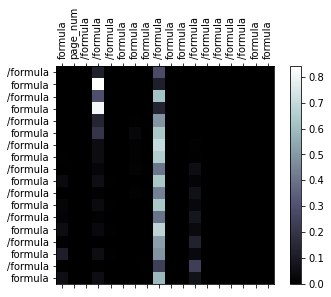

> /ref /label /label formula /formula ref label formula lText /formula /formula formula formula ref /lText formula lText /lText /label label /ref /formula instruction label /formula question
= question label /label instruction formula /formula lText formula /formula label /label /lText lText formula /formula label /label /lText formula /formula ref /ref ref /ref formula /formula
< /formula formula /formula formula /formula formula /formula formula /formula formula /formula formula /formula formula /formula formula /formula formula
bleu: 5.752437154826155e-155



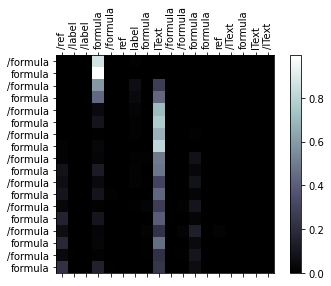

> lText formula formula label formula formula /formula /formula /lText lText /formula /label instruction /ref label /formula /formula /label /ref formula ref /label question ref /lText label
= question label /label instruction formula /formula lText formula /formula label /label /lText lText formula /formula label /label /lText formula /formula ref /ref ref /ref formula /formula
< question formula /formula formula /formula formula /formula formula /formula formula /formula formula /formula formula /formula formula /formula formula
bleu: 5.891149635855408e-155



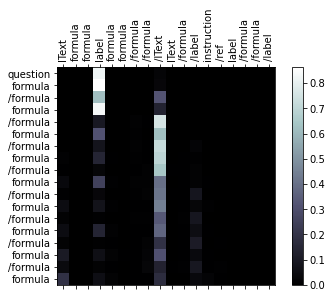

> formula info instruction formula formula /formula label /info /formula info question /info /label formula /formula
= question label /label info /info info /info instruction formula /formula formula /formula formula /formula formula
< /formula formula formula /formula formula /formula formula /formula formula /formula formula /formula formula /formula formula /formula formula /formula
bleu: 0.34823528327578535



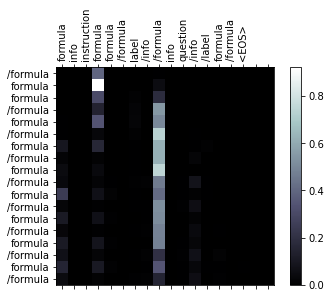

> formula /page_num /formula /formula page_num formula
= formula /formula formula /formula page_num /page_num
< /formula formula /formula formula /formula formula /formula formula /formula formula /formula formula /formula formula /formula formula /formula formula
bleu: 0.1431712315455507



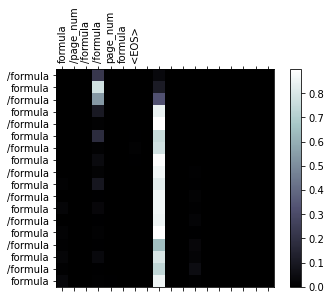

> /formula formula /formula /formula /page_num /formula /instruction formula formula formula page_num formula /formula /formula
= /formula formula /formula formula /formula formula /formula formula /formula formula /formula /instruction page_num /page_num
< /formula formula /formula formula /formula formula /formula formula /formula formula /formula formula /formula formula /formula formula /formula formula
bleu: 0.6102169202557912



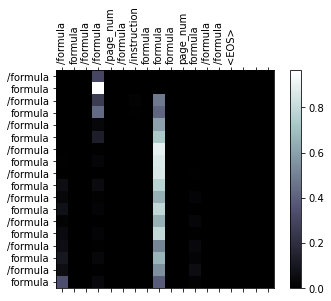

> question /formula formula info /label formula info instruction label formula formula /formula /info /info /formula
= question label /label info /info info /info instruction formula /formula formula /formula formula /formula formula
< question formula /formula formula /formula formula /formula formula /formula formula /formula formula /formula formula /formula formula /formula formula
bleu: 0.360056585428503



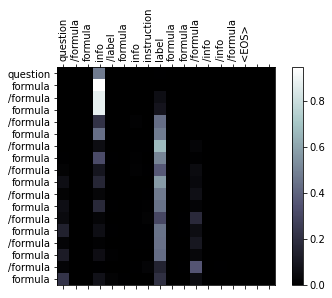

> /label question /question formula /formula /formula label instruction question label formula instruction formula /label /formula label /formula /label /formula instruction question /instruction formula /instruction formula formula /question /formula formula
= question label /label instruction formula /formula /instruction /question question label /label instruction formula /formula formula /formula formula /formula /instruction /question question label /label instruction formula /formula formula /formula formula
< /formula formula /formula formula /formula formula /formula formula /formula formula /formula formula /formula formula /formula formula /formula formula
bleu: 0.26226780934588995



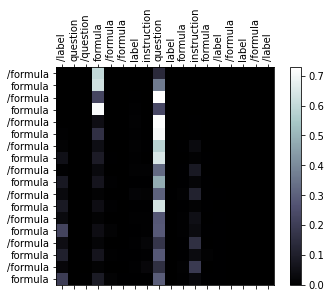

> formula formula formula formula /formula /info /formula /formula formula formula /formula formula /label formula /formula formula info formula formula label /formula /info /formula /formula instruction formula /formula formula question info /formula /formula /formula /formula /formula formula
= question label /label info /info info /info instruction formula /formula formula /formula formula /formula formula /formula formula /formula formula /formula formula /formula formula /formula formula /formula formula /formula formula /formula formula /formula formula /formula formula /formula
< question formula /formula formula /formula formula /formula formula /formula formula /formula formula /formula formula /formula formula /formula formula
bleu: 0.31050449532439495



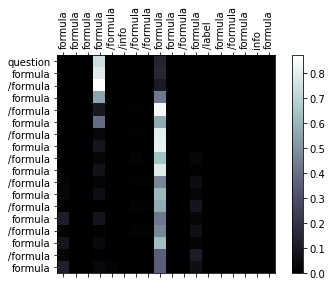

[0.1431712315455507,
 0.49367278838913037,
 5.752437154826155e-155,
 5.891149635855408e-155,
 0.34823528327578535,
 0.1431712315455507,
 0.6102169202557912,
 0.360056585428503,
 0.26226780934588995,
 0.31050449532439495]

In [14]:
evaluate_batch_randomly(seq2seq_lstm_model, test_pairs, n=10)